# CNN

In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# 이미지 크기가 제각각이라 맞춤
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [179]:
filenames=os.listdir("doro")
categories=[]  # sleep : 1, wake : 0 => y 데이터 추가
for fn in filenames: 
    ct=fn.split("_")[0]
    if ct=='sidewalk':
        categories.append(1)
    else:
        categories.append(0)

In [180]:
len(categories)

226

In [181]:
df=pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})
df

,filename,category
0,driveway_1.jpg,0
1,driveway_10.jpg,0
2,driveway_100.jpg,0
3,driveway_11.jpg,0
4,driveway_12.jpg,0
...,...,...
221,sidewalk_95.jpg,1
222,sidewalk_96.jpg,1
223,sidewalk_97.jpg,1
224,sidewalk_98.jpg,1


In [182]:
sample=random.choice(filenames)  # 사진 샘플 하나 뽑기

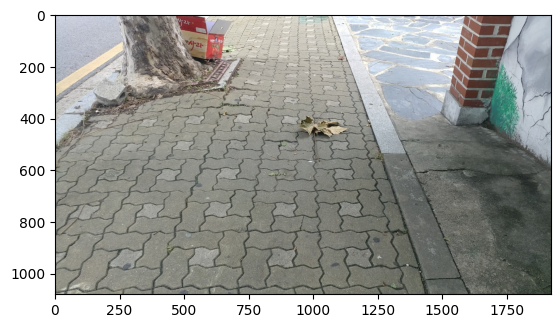

In [183]:
img=load_img("doro/"+sample) # 이미지 로드
plt.imshow(img)

In [64]:
# model = Sequential()
# # Conv2D : 1D(1차원, 길게~), 2D(2차원, 사각영역), 3D(영상)
# model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(2, activation='softmax'))

In [65]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
# model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_20 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_21 (Bat  (None, 109, 109, 64)    

In [184]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(224,224,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 26, 26, 64)     

In [185]:
earlystop = EarlyStopping(patience=20) # 10번이상 모델이 개선되지 않으면 멈춤

In [186]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)  # learning_rate의 하한값

In [187]:
callbacks = [earlystop, learning_rate_reduction]

In [188]:
df["category"] = df["category"].replace({1: 'sidewalk', 0: 'driveway'})

In [189]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

In [190]:
total_train = train_df.shape[0]  # train_df : 증식시켜야 할 데이터 
total_validate = validate_df.shape[0]
batch_size=15

In [191]:
# 이미지 증식
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [192]:
# flow_from_dataframe
# train_df : 증식시켜야 할 데이터가 데이터프레임이므로
train_generator=train_datagen.flow_from_dataframe(
    train_df,
    "doro/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 180 validated image filenames belonging to 2 classes.


In [193]:
# validation 데이터는 증식하면 안됨
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "doro/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 46 validated image filenames belonging to 2 classes.


In [194]:
epochs=100

In [195]:
batch_size=15

In [196]:
history=model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\tjdbs\AppData\Local\Temp\ipykernel_2052\2628817000.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(


Epoch 1/100
12/12 [==============================] - 22s 2s/step - loss: 1.0342 - accuracy: 0.4278 - val_loss: 0.6879 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - 16s 1s/step - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6744 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - 15s 1s/step - loss: 0.6978 - accuracy: 0.4389 - val_loss: 0.6719 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 4/100
12/12 [==============================] - 15s 1s/step - loss: 0.6941 - accuracy: 0.5222 - val_loss: 0.6580 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 5/100
12/12 [==============================] - 16s 1s/step - loss: 0.7049 - accuracy: 0.5444 - val_loss: 0.7758 - val_accuracy: 0.2889 - lr: 0.0010
Epoch 6/100
12/12 [==============================] - 20s 2s/step - loss: 0.6824 - accuracy: 0.5833 - val_loss: 0.6345 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 7/100
12/12 [==============================] - 23s 2s/step - loss: 0.6

12/12 [==============================] - 13s 1s/step - loss: 0.6450 - accuracy: 0.6611 - val_loss: 0.6102 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 22/100
12/12 [==============================] - 13s 1s/step - loss: 0.5902 - accuracy: 0.6944 - val_loss: 0.7917 - val_accuracy: 0.5111 - lr: 0.0010
Epoch 23/100
12/12 [==============================] - 13s 1s/step - loss: 0.6316 - accuracy: 0.6556 - val_loss: 0.6112 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 24/100
12/12 [==============================] - 14s 1s/step - loss: 0.6451 - accuracy: 0.6556 - val_loss: 0.5866 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 25/100
12/12 [==============================] - 14s 1s/step - loss: 0.6058 - accuracy: 0.6444 - val_loss: 0.6652 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 26/100
12/12 [==============================] - 18s 1s/step - loss: 0.5670 - accuracy: 0.7000 - val_loss: 0.7036 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 27/100
12/12 [==============================] - 17s 1s/step - loss: 0.5828 - 

12/12 [==============================] - 13s 1s/step - loss: 0.4486 - accuracy: 0.7722 - val_loss: 0.6207 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 43/100
12/12 [==============================] - 13s 1s/step - loss: 0.4232 - accuracy: 0.7889 - val_loss: 0.6745 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 44/100
12/12 [==============================] - 14s 1s/step - loss: 0.3864 - accuracy: 0.8278 - val_loss: 0.8367 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 45/100
12/12 [==============================] - 13s 1s/step - loss: 0.4439 - accuracy: 0.7889 - val_loss: 0.6186 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 46/100
12/12 [==============================] - 13s 1s/step - loss: 0.4138 - accuracy: 0.7778 - val_loss: 0.6153 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 47/100
12/12 [==============================] - 14s 1s/step - loss: 0.4340 - accuracy: 0.7889 - val_loss: 0.6585 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 48/100
12/12 [==============================] - 13s 1s/step - loss: 0.4477 - 

12/12 [==============================] - 14s 1s/step - loss: 0.2967 - accuracy: 0.8833 - val_loss: 0.4628 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 63/100
12/12 [==============================] - 13s 1s/step - loss: 0.3387 - accuracy: 0.8667 - val_loss: 0.4447 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 64/100
12/12 [==============================] - 14s 1s/step - loss: 0.2578 - accuracy: 0.8833 - val_loss: 0.4956 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 65/100
12/12 [==============================] - 14s 1s/step - loss: 0.2624 - accuracy: 0.9056 - val_loss: 0.4652 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 66/100
12/12 [==============================] - 14s 1s/step - loss: 0.2546 - accuracy: 0.9111 - val_loss: 0.4096 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 67/100
12/12 [==============================] - 14s 1s/step - loss: 0.1787 - accuracy: 0.9389 - val_loss: 0.5474 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 68/100
12/12 [==============================] - 13s 1s/step - loss: 0.2215 - 

12/12 [==============================] - 14s 1s/step - loss: 0.1732 - accuracy: 0.9444 - val_loss: 0.4156 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 84/100
12/12 [==============================] - 13s 1s/step - loss: 0.1448 - accuracy: 0.9444 - val_loss: 0.3305 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 85/100
12/12 [==============================] - 14s 1s/step - loss: 0.0899 - accuracy: 0.9667 - val_loss: 0.4901 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 86/100
12/12 [==============================] - 14s 1s/step - loss: 0.1984 - accuracy: 0.9333 - val_loss: 0.4309 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 87/100
12/12 [==============================] - 14s 1s/step - loss: 0.1480 - accuracy: 0.9278 - val_loss: 0.2690 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 88/100
12/12 [==============================] - 14s 1s/step - loss: 0.1437 - accuracy: 0.9389 - val_loss: 0.3543 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 89/100
12/12 [==============================] - 13s 1s/step - loss: 0.1145 - 

In [197]:
model.save("./cnn_model_2class.h5")

In [198]:
import wget
wget.download("https://raw.githubusercontent.com/gauravreddy08/deep-learning-tensorflow/main/extras/helper_function.py")

100% [..............................................................................] 10246 / 10246

'helper_function (6).py'

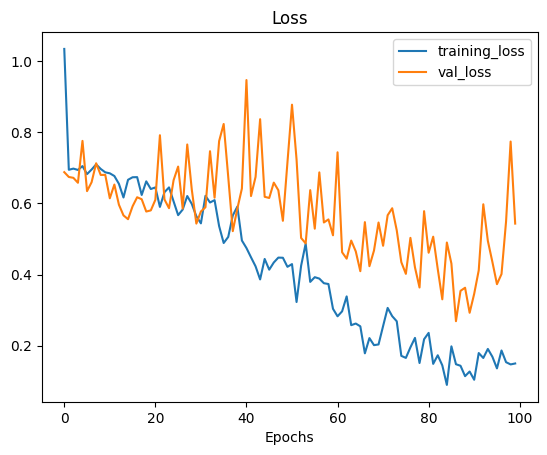

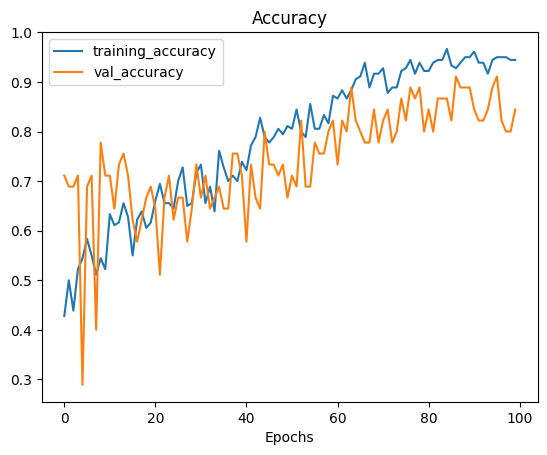

In [199]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
# ax1.plot(history.history['loss'], color='b', label="Training loss")
# ax1.plot(history.history['val_loss'], color='r', label="validation loss")
# ax1.set_xticks(np.arange(1, epochs, 5))
# ax1.set_yticks(np.arange(0, 1, 0.1))

# ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
# ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
# ax2.set_xticks(np.arange(1, epochs, 5))

# legend = plt.legend(loc='best', shadow=True)
# plt.tight_layout()
# plt.show()

from helper_function import plot_loss_curves
plot_loss_curves(history)

In [214]:
#test
test_filenames = os.listdir("cnn_test_img")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [215]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "cnn_test_img/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 14 validated image filenames.


In [216]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\tjdbs\AppData\Local\Temp\ipykernel_2052\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [217]:
test_df['category'] = np.argmax(predict, axis=-1)

In [218]:
test_df['category'] = test_df['category'].replace({'sidewalk': 1, 'driveway': 0})

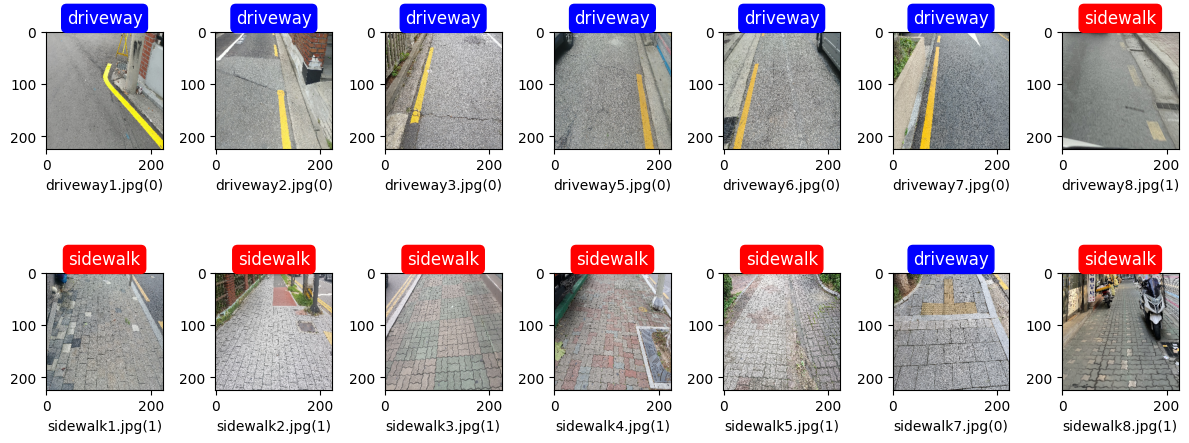

In [220]:
sample_test = test_df.head(14)
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("cnn_test_img/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(5, 7, index+1  )
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
    
    if category==0:
        plt.title(f"driveway", color='white', 
                  bbox=dict(boxstyle="round", 
                            color='blue'))
    else:
        plt.title(f"sidewalk", color='white', 
          bbox=dict(boxstyle="round", 
                    color='red'))
plt.tight_layout()
plt.show()
# 정답 : driveway = 0, sidewalk = 1
## model1 : 10/12 맞음
## model2 : 5/12 맞음
## model3 : 13/14